In [ ]:
print('Data preprocessing started')

Data preprocessing started


In [31]:
# reading data on google drive
from google.colab import drive
# Mount your Google Drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

# Load CSV file from Google Drive
file_path = '/content/drive/MyDrive/other/data/Data for MSC Thesis/eth_householdgeovariables_y5.csv'
df = pd.read_csv(file_path)

print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
        household_id  dist_road  dist_market  dist_border  dist_popcenter  \
0  20101010100104011        7.7   162.300003    82.900002             0.4   
1  20101010100104022        7.7   162.300003    82.900002             0.4   
2  20101010100104033        7.7   162.300003    82.900002             0.4   
3  20101010100104044        7.7   162.300003    82.900002             0.4   
4  20101010100104055        7.7   162.300003    82.900002             0.4   

   dist_admhq  af_bio_1_x  af_bio_8_x  af_bio_12_x  af_bio_13_x  ...  \
0         0.0         283         307          184           47  ...   
1         0.0         283         307          184           47  ...   
2         0.0         283         307          184           47  ...   
3         0.0         283         307          184           47  ...   
4         0.0         283         307          1

In [32]:
# ------------------------------
# DATA EXPLORATION: NULL AND OUTLIER PERCENTAGE
# ------------------------------

# ------------------------------
# Step 1: Dataset Overview
# ------------------------------
print("----- Dataset Info -----")
print(df.info())

print("\n----- Dataset Shape -----")
print(df.shape)

print("\n----- Statistical Summary -----")
print(df.describe())

# ------------------------------
# Step 2: Missing Values by Percentage
# ------------------------------
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print("\n----- Missing Values Summary -----")
print(missing_df.sort_values(by='Percentage', ascending=False))

# ------------------------------
# Step 3: Outlier Detection by Percentage (Numeric Columns Only)
# ------------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

outlier_summary = []
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    outlier_count = len(outliers)
    outlier_percent = (outlier_count / len(df)) * 100

    outlier_summary.append([col, outlier_count, outlier_percent])

outlier_df = pd.DataFrame(outlier_summary, columns=['Column', 'Outlier Count', 'Outlier %'])
print("\n----- Outlier Summary by Percentage -----")
print(outlier_df.sort_values(by='Outlier %', ascending=False))

----- Dataset Info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4890 entries, 0 to 4889
Data columns (total 52 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   household_id       4890 non-null   int64  
 1   dist_road          4890 non-null   float64
 2   dist_market        4890 non-null   float64
 3   dist_border        4890 non-null   float64
 4   dist_popcenter     4890 non-null   float64
 5   dist_admhq         4890 non-null   float64
 6   af_bio_1_x         4890 non-null   int64  
 7   af_bio_8_x         4890 non-null   int64  
 8   af_bio_12_x        4890 non-null   int64  
 9   af_bio_13_x        4890 non-null   int64  
 10  af_bio_16_x        4890 non-null   int64  
 11  afmnslp_pct        4890 non-null   int64  
 12  srtm_1k            4890 non-null   int64  
 13  popdensity         4890 non-null   int64  
 14  cropshare          4890 non-null   int64  
 15  sq1                4890 non-null   int64  
 16 

In [33]:
# ------------------------------
# FULL PREPROCESSING PIPELINE WITH SMOTE (NO WARNINGS)
# ------------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# ------------------------------
# Step 1: Drop irrelevant/empty columns
# ------------------------------
drop_cols = [col for col in df.columns if col == "household_id" or col.startswith("c2_")]
df = df.drop(columns=drop_cols, errors="ignore")

# ------------------------------
# Step 2: Impute missing values (no chained assignment)
# ------------------------------
df['lat_dd_mod'] = df['lat_dd_mod'].fillna(df['lat_dd_mod'].median())
df['lon_dd_mod'] = df['lon_dd_mod'].fillna(df['lon_dd_mod'].median())

# ------------------------------
# Step 3: Handle outliers
# ------------------------------
outlier_cols = ['sq4', 'h2021_wetQ', 'dist_road', 'h2021_sen', 'sen_avg']

for col in outlier_cols:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] > upper, upper,
                           np.where(df[col] < lower, lower, df[col]))

# ------------------------------
# Step 4: Encode categorical variables
# ------------------------------
categorical_cols = ['ssa_aez09', 'landcov']
categorical_cols = [col for col in categorical_cols if col in df.columns]

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# ------------------------------
# Step 5: Scale numeric features
# ------------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if "suppress" in numeric_cols:
    numeric_cols.remove("suppress")

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# ------------------------------
# Step 6: Train-test split
# ------------------------------
X = df.drop("suppress", axis=1)
y = df["suppress"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------------
# Step 7: SMOTE
# ------------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# ------------------------------
# Output summary
# ------------------------------
print("Preprocessing complete with SMOTE!")
print(f"Original training set shape: {X_train.shape}, positives: {y_train.sum()}")
print(f"Resampled training set shape: {X_train_res.shape}, positives: {y_train_res.sum()}")
print(f"Test set shape: {X_test.shape}, positives: {y_test.sum()}")


Preprocessing complete with SMOTE!
Original training set shape: (3912, 54), positives: 34
Resampled training set shape: (7756, 54), positives: 3878
Test set shape: (978, 54), positives: 9


FEATURE SELECTION PIPELINE
Checking data availability...
X_train shape: (3912, 54)
y_train shape: (3912,)
Using resampled data

Data ready: X shape = (7756, 54), y shape = (7756,)

1. Correlation & Multicollinearity Analysis:
Top 10 features by correlation with target:
              Feature  Abs_Correlation
13          cropshare         0.853250
12         popdensity         0.847370
21             twi_ne         0.802427
10        afmnslp_pct         0.738956
11            srtm_1k         0.717419
20                sq7         0.707368
6          af_bio_8_x         0.684696
5          af_bio_1_x         0.660612
1         dist_market         0.645827
22  pct_urban_cluster         0.608777

Highly correlated features to consider dropping: ['af_bio_8_x', 'af_bio_13_x', 'af_bio_16_x', 'srtm_1k', 'sq2', 'sq5', 'sq6', 'sq7', 'h2021_tot', 'h2021_wetQ', 'anntot_avg', 'wetQ_avg', 'eviarea_avg', 'evimax_avg', 'h2021_eviarea', 'h2021_evimax', 'h2021_grn', 'landcov_Built-up', 'landcov_Cropland']

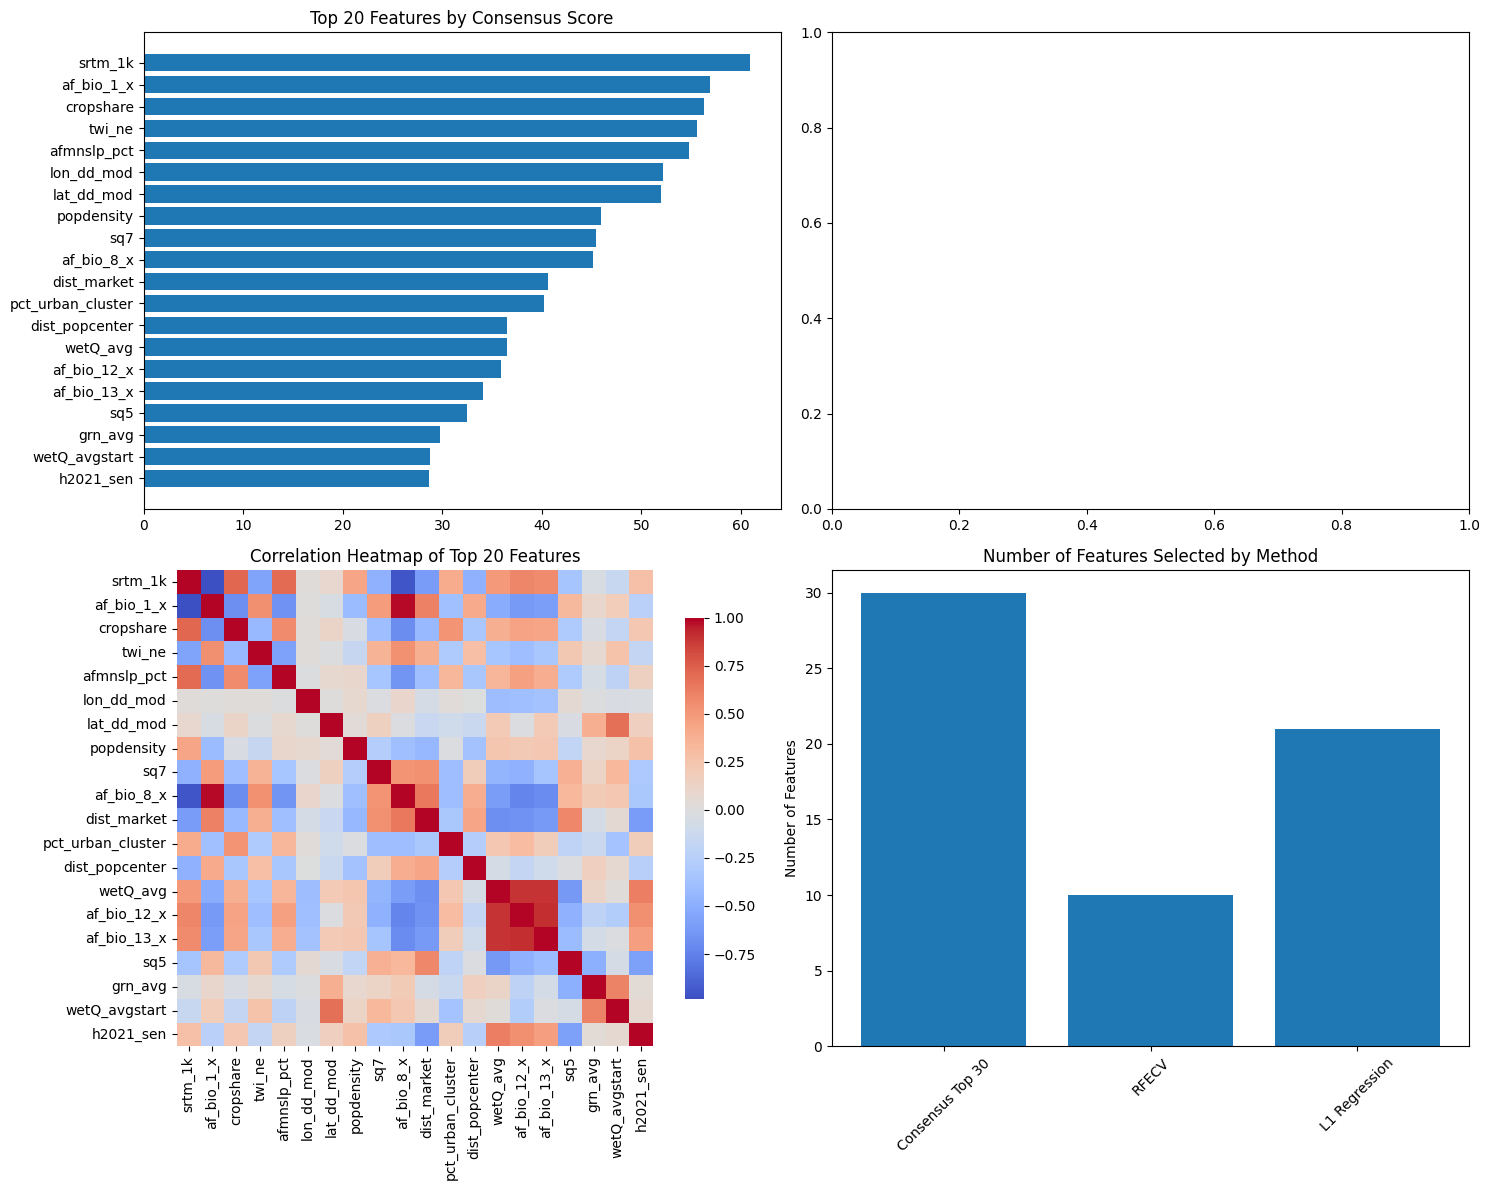


Feature sets created and ready for model training!


In [35]:
# ------------------------------
# FEATURE SELECTION PIPELINE (MULTI-METHOD)
# ------------------------------
import numpy as np
import pandas as pd
from sklearn.feature_selection import (
    RFE, RFECV, SelectKBest,
    f_classif, mutual_info_classif,
    SelectFromModel
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

print("="*60)
print("FEATURE SELECTION PIPELINE")
print("="*60)

# --------------------------------------------------------
# METHOD 1: Correlation Analysis & Multicollinearity
# --------------------------------------------------------
print("\n1. Correlation & Multicollinearity Analysis:")

# Calculate feature correlations with target
correlations = []
for col in X_train.columns:
    if pd.api.types.is_numeric_dtype(X_train[col]):
        corr, _ = spearmanr(X_train[col], y_train)
        correlations.append((col, abs(corr)))

correlations_df = pd.DataFrame(correlations, columns=['Feature', 'Abs_Correlation'])
correlations_df = correlations_df.sort_values('Abs_Correlation', ascending=False)

# Identify highly correlated features (threshold > 0.8)
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.8)]

print(f"Top 10 features by correlation with target:")
print(correlations_df.head(10))
print(f"\nHighly correlated features to consider dropping: {high_corr_features}")

# --------------------------------------------------------
# METHOD 2: Filter Methods
# --------------------------------------------------------
print("\n2. Filter Method - SelectKBest:")

# ANOVA F-value
selector_f = SelectKBest(f_classif, k='all')
selector_f.fit(X_train, y_train)
f_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'F_Score': selector_f.scores_,
    'P_Value': selector_f.pvalues_
}).sort_values('F_Score', ascending=False)

# Mutual Information
selector_mi = SelectKBest(mutual_info_classif, k='all')
selector_mi.fit(X_train, y_train)
mi_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'MI_Score': selector_mi.scores_
}).sort_values('MI_Score', ascending=False)

print("Top 10 features by ANOVA F-Score:")
print(f_scores.head(10))
print("\nTop 10 features by Mutual Information:")
print(mi_scores.head(10))

# --------------------------------------------------------
# METHOD 3: Wrapper Method - RFECV
# --------------------------------------------------------
print("\n3. Wrapper Method - RFECV:")

# Use a fast estimator for RFECV
estimator_rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    max_depth=5  # Limit depth for speed
)

rfecv = RFECV(
    estimator=estimator_rf,
    step=1,
    cv=StratifiedKFold(3),  # Reduced for speed
    scoring='roc_auc',
    min_features_to_select=10,
    n_jobs=-1
)

print("Running RFECV (this may take a few minutes)...")
rfecv.fit(X_train, y_train)

rfecv_features = X_train.columns[rfecv.support_].tolist()
print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected {len(rfecv_features)} features via RFECV")

# --------------------------------------------------------
# METHOD 4: Embedded Methods
# --------------------------------------------------------
print("\n4. Embedded Methods:")

# Random Forest Feature Importance
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'RF_Importance': rf.feature_importances_
}).sort_values('RF_Importance', ascending=False)

# XGBoost Feature Importance
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
xgb_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'XGB_Importance': xgb_model.feature_importances_
}).sort_values('XGB_Importance', ascending=False)

print("Top 10 features by Random Forest Importance:")
print(rf_importance.head(10))
print("\nTop 10 features by XGBoost Importance:")
print(xgb_importance.head(10))

# SelectFromModel with Logistic Regression (L1 regularization)
logreg = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    random_state=42,
    max_iter=1000
)
logreg.fit(X_train, y_train)
sfm = SelectFromModel(logreg, prefit=True)
sfm_features = X_train.columns[sfm.get_support()].tolist()
print(f"\nFeatures selected by L1 Logistic Regression: {len(sfm_features)} features")

# --------------------------------------------------------
# METHOD 5: Feature Aggregation & Consensus
# --------------------------------------------------------
print("\n5. Feature Selection Consensus:")

# Create a scoring dataframe
feature_scores = pd.DataFrame({'Feature': X_train.columns})

# Normalize scores from different methods
feature_scores['F_Score_Rank'] = f_scores['F_Score'].rank(ascending=False)
feature_scores['MI_Score_Rank'] = mi_scores['MI_Score'].rank(ascending=False)
feature_scores['RF_Importance_Rank'] = rf_importance['RF_Importance'].rank(ascending=False)
feature_scores['XGB_Importance_Rank'] = xgb_importance['XGB_Importance'].rank(ascending=False)
feature_scores['RFECV_Selected'] = rfecv.support_.astype(int)
feature_scores['L1_Selected'] = feature_scores['Feature'].isin(sfm_features).astype(int)

# Calculate consensus score (weighted average)
feature_scores['Consensus_Score'] = (
    feature_scores['F_Score_Rank'] * 0.2 +
    feature_scores['MI_Score_Rank'] * 0.2 +
    feature_scores['RF_Importance_Rank'] * 0.3 +
    feature_scores['XGB_Importance_Rank'] * 0.3
)

# Add inverse so higher is better
feature_scores['Consensus_Score'] = len(feature_scores) - feature_scores['Consensus_Score']
feature_scores = feature_scores.sort_values('Consensus_Score', ascending=False)

print("\nTop 20 features by Consensus Score:")
print(feature_scores[['Feature', 'Consensus_Score', 'RFECV_Selected', 'L1_Selected']].head(20))

# --------------------------------------------------------
# RECOMMENDED FEATURE SETS
# --------------------------------------------------------
print("\n" + "="*60)
print("RECOMMENDED FEATURE SETS")
print("="*60)

# Set 1: Top features by consensus (30 features)
top_n = 30
features_set1 = feature_scores.head(top_n)['Feature'].tolist()
print(f"\nSet 1: Top {top_n} features by consensus:")
print(features_set1)

# Set 2: RFECV selected features
features_set2 = rfecv_features
print(f"\nSet 2: RFECV selected features ({len(features_set2)}):")
print(features_set2)

# Set 3: Intersection of top methods
features_set3 = list(set(features_set1[:20]) & set(features_set2))
print(f"\nSet 3: Intersection of top consensus and RFECV ({len(features_set3)}):")
print(features_set3)

# --------------------------------------------------------
# VISUALIZATION
# --------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Top features by consensus
top_20 = feature_scores.head(20)
axes[0, 0].barh(top_20['Feature'], top_20['Consensus_Score'])
axes[0, 0].set_title('Top 20 Features by Consensus Score')
axes[0, 0].invert_yaxis()

# 2. RFECV cross-validation scores
axes[0, 1].plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
                rfecv.cv_results_['mean_test_score'])
axes[0, 1].fill_between(range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
                        rfecv.cv_results_['mean_test_score'] - rfecv.cv_results_['std_test_score'],
                        rfecv.cv_results_['mean_test_score'] + rfecv.cv_results_['std_test_score'],
                        alpha=0.2)
axes[0, 1].set_xlabel('Number of features selected')
axes[0, 1].set_ylabel('Cross validation score (ROC AUC)')
axes[0, 1].set_title('RFECV Performance')

# 3. Top 10 from each method
methods = ['RF_Importance', 'XGB_Importance', 'F_Score', 'MI_Score']
for i, method in enumerate(methods):
    if method == 'RF_Importance':
        data = rf_importance.head(10)
    elif method == 'XGB_Importance':
        data = xgb_importance.head(10)
    elif method == 'F_Score':
        data = f_scores.head(10)
    else:
        data = mi_scores.head(10)

    axes[1, i//2].barh(data['Feature'], data[method.split('_')[0] + '_Score' if '_Score' in method else method])
    axes[1, i//2].set_title(f'Top 10 by {method}')
    axes[1, i//2].invert_yaxis()

plt.tight_layout()
plt.show()


In [36]:
# ------------------------------
# MODEL TRAINING WITH ADJUSTED FEATURES
# ------------------------------
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
    VotingClassifier
)
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc
)
from sklearn.model_selection import cross_val_score
import time
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def train_and_evaluate_with_features(feature_set_name, feature_set, X_train, X_test, y_train, y_test):
    """
    Train and evaluate models with a specific feature set
    """
    print(f"\n{'='*80}")
    print(f"TRAINING WITH FEATURE SET: {feature_set_name}")
    print(f"Number of features: {len(feature_set)}")
    print('='*80)

    # Check which features actually exist
    existing_features = [f for f in feature_set if f in X_train.columns]
    missing_features = [f for f in feature_set if f not in X_train.columns]

    if missing_features:
        print(f"Warning: {len(missing_features)} features not found in data:")
        print(missing_features[:10], "..." if len(missing_features) > 10 else "")

    if len(existing_features) == 0:
        print("ERROR: No existing features found!")
        return None, None, None, None

    print(f"Using {len(existing_features)} existing features")

    # Prepare data with selected features
    X_train_selected = X_train[existing_features].copy()
    X_test_selected = X_test[existing_features].copy()

    # --------------------------------------------------------
    # Define models (optimized for imbalanced data)
    # --------------------------------------------------------
    models = {
        'Logistic Regression': LogisticRegression(
            class_weight='balanced',
            random_state=42,
            max_iter=1000,
            n_jobs=-1,
            C=0.1
        ),

        'Random Forest': RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ),

        'XGBoost': XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42,
            n_jobs=-1
        ),

        'LightGBM': LGBMClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            num_leaves=31,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            verbose=-1
        ),

        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.1,
            subsample=0.8,
            random_state=42
        )
    }

    # --------------------------------------------------------
    # Training and evaluation
    # --------------------------------------------------------
    results = []
    model_objects = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")
        start_time = time.time()

        try:
            # Train model
            model.fit(X_train_selected, y_train)
            train_time = time.time() - start_time

            # Predictions
            y_pred = model.predict(X_test_selected)
            y_pred_proba = model.predict_proba(X_test_selected)[:, 1]

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            roc_auc = roc_auc_score(y_test, y_pred_proba)

            # Cross-validation score
            cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5,
                                       scoring='roc_auc', n_jobs=-1)

            # Store results
            result = {
                'Feature_Set': feature_set_name,
                'Model': name,
                'Num_Features': len(existing_features),
                'Accuracy': round(accuracy, 4),
                'Precision': round(precision, 4),
                'Recall': round(recall, 4),
                'F1-Score': round(f1, 4),
                'ROC-AUC': round(roc_auc, 4),
                'CV_ROC_AUC_Mean': round(cv_scores.mean(), 4),
                'CV_ROC_AUC_Std': round(cv_scores.std(), 4),
                'Train_Time_s': round(train_time, 2)
            }

            results.append(result)
            model_objects[name] = {
                'model': model,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }

            print(f"  F1-Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}, Recall: {recall:.4f}")

        except Exception as e:
            print(f"  ERROR training {name}: {e}")

    if not results:
        print("No models trained successfully!")
        return None, None, None, None

    results_df = pd.DataFrame(results)

    # Create ensemble of top 2 models by F1-Score
    if len(results_df) >= 2:
        top_2_models = results_df.nlargest(2, 'F1-Score')['Model'].tolist()
        print(f"\nCreating ensemble with: {top_2_models}")

        ensemble_estimators = [(name, model_objects[name]['model']) for name in top_2_models]
        voting_clf = VotingClassifier(estimators=ensemble_estimators, voting='soft')
        voting_clf.fit(X_train_selected, y_train)

        # Evaluate ensemble
        y_pred_ensemble = voting_clf.predict(X_test_selected)
        y_pred_proba_ensemble = voting_clf.predict_proba(X_test_selected)[:, 1]

        ensemble_result = {
            'Feature_Set': feature_set_name,
            'Model': 'Ensemble (Voting)',
            'Num_Features': len(existing_features),
            'Accuracy': round(accuracy_score(y_test, y_pred_ensemble), 4),
            'Precision': round(precision_score(y_test, y_pred_ensemble, zero_division=0), 4),
            'Recall': round(recall_score(y_test, y_pred_ensemble, zero_division=0), 4),
            'F1-Score': round(f1_score(y_test, y_pred_ensemble, zero_division=0), 4),
            'ROC-AUC': round(roc_auc_score(y_test, y_pred_proba_ensemble), 4),
            'CV_ROC_AUC_Mean': None,
            'CV_ROC_AUC_Std': None,
            'Train_Time_s': None
        }

        results_df = pd.concat([results_df, pd.DataFrame([ensemble_result])], ignore_index=True)

        # Add ensemble to model objects
        model_objects['Ensemble'] = {
            'model': voting_clf,
            'y_pred': y_pred_ensemble,
            'y_pred_proba': y_pred_proba_ensemble
        }

    return results_df, model_objects, X_train_selected, X_test_selected

# --------------------------------------------------------
# Main training loop
# --------------------------------------------------------
if 'adjusted_feature_sets' in locals() and adjusted_feature_sets:
    all_results = []
    best_models = {}

    # Test each feature set
    for set_name, feature_set in adjusted_feature_sets.items():
        print(f"\n\n{'#'*80}")
        print(f"PROCESSING FEATURE SET: {set_name}")
        print(f"{'#'*80}")

        results_df, models, X_train_sel, X_test_sel = train_and_evaluate_with_features(
            set_name, feature_set, X_train, X_test, y_train, y_test
        )

        if results_df is not None:
            all_results.append(results_df)

            # Find best model for this feature set
            best_for_set = results_df.loc[results_df['F1-Score'].idxmax()]
            print(f"\nBest model for {set_name}: {best_for_set['Model']} with F1-Score: {best_for_set['F1-Score']:.4f}")

            best_models[set_name] = {
                'model': models[best_for_set['Model']]['model'],
                'features': feature_set,
                'metrics': best_for_set
            }

    if all_results:
        # Combine all results
        final_results = pd.concat(all_results, ignore_index=True)

        # Display overall comparison
        print("\n" + "="*80)
        print("OVERALL MODEL COMPARISON")
        print("="*80)

        # Sort by F1-Score
        sorted_results = final_results.sort_values('F1-Score', ascending=False)
        print(sorted_results.to_string(index=False))

        # Find overall best model
        overall_best = sorted_results.iloc[0]
        print(f"\n{'='*80}")
        print(f"OVERALL BEST MODEL:")
        print(f"Model: {overall_best['Model']}")
        print(f"Feature Set: {overall_best['Feature_Set']}")
        print(f"F1-Score: {overall_best['F1-Score']:.4f}")
        print(f"Recall: {overall_best['Recall']:.4f}")
        print(f"ROC-AUC: {overall_best['ROC-AUC']:.4f}")
        print(f"Precision: {overall_best['Precision']:.4f}")
        print('='*80)

        # --------------------------------------------------------
        # Visualizations
        # --------------------------------------------------------
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. F1-Score comparison
        try:
            pivot_f1 = final_results.pivot_table(index='Model', columns='Feature_Set', values='F1-Score')
            pivot_f1.plot(kind='bar', ax=axes[0, 0])
            axes[0, 0].set_title('F1-Score by Model and Feature Set')
            axes[0, 0].set_ylabel('F1-Score')
            axes[0, 0].tick_params(axis='x', rotation=45)
            axes[0, 0].legend(title='Feature Set', bbox_to_anchor=(1.05, 1), loc='upper left')
        except:
            axes[0, 0].text(0.5, 0.5, 'Could not create F1-Score comparison\n(not enough data)',
                          ha='center', va='center', fontsize=12)

        # 2. ROC-AUC comparison
        try:
            pivot_auc = final_results.pivot_table(index='Model', columns='Feature_Set', values='ROC-AUC')
            pivot_auc.plot(kind='bar', ax=axes[0, 1])
            axes[0, 1].set_title('ROC-AUC by Model and Feature Set')
            axes[0, 1].set_ylabel('ROC-AUC')
            axes[0, 1].tick_params(axis='x', rotation=45)
            axes[0, 1].legend(title='Feature Set', bbox_to_anchor=(1.05, 1), loc='upper left')
        except:
            axes[0, 1].text(0.5, 0.5, 'Could not create ROC-AUC comparison\n(not enough data)',
                          ha='center', va='center', fontsize=12)

        # 3. Feature importance for best model
        if best_models:
            best_set_name = overall_best['Feature_Set']
            if best_set_name in best_models:
                best_model_obj = best_models[best_set_name]['model']

                if hasattr(best_model_obj, 'feature_importances_'):
                    # Get feature importance
                    feature_importance = pd.DataFrame({
                        'Feature': X_train_sel.columns,
                        'Importance': best_model_obj.feature_importances_
                    }).sort_values('Importance', ascending=False)

                    # Plot top 15 features
                    top_15 = feature_importance.head(15)
                    axes[1, 0].barh(range(len(top_15)), top_15['Importance'])
                    axes[1, 0].set_yticks(range(len(top_15)))
                    axes[1, 0].set_yticklabels(top_15['Feature'])
                    axes[1, 0].invert_yaxis()
                    axes[1, 0].set_xlabel('Importance')
                    axes[1, 0].set_title(f'Top 15 Features - {overall_best["Model"]}')
                else:
                    axes[1, 0].text(0.5, 0.5, 'No feature importances available\nfor this model type',
                                  ha='center', va='center', fontsize=12)

        # 4. Confusion matrix for best model
        if best_models and 'Ensemble' in model_objects:
            cm = confusion_matrix(y_test, model_objects['Ensemble']['y_pred'])
            im = axes[1, 1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            axes[1, 1].set_title('Confusion Matrix (Ensemble)')
            axes[1, 1].set_ylabel('True label')
            axes[1, 1].set_xlabel('Predicted label')

            # Add text annotations
            thresh = cm.max() / 2.
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    axes[1, 1].text(j, i, format(cm[i, j], 'd'),
                                   ha="center", va="center",
                                   color="white" if cm[i, j] > thresh else "black")
        else:
            axes[1, 1].text(0.5, 0.5, 'No confusion matrix available',
                          ha='center', va='center', fontsize=12)

        plt.tight_layout()
        plt.show()

        # --------------------------------------------------------
        # Save best model
        # --------------------------------------------------------
        if best_set_name in best_models:
            best_model_obj = best_models[best_set_name]['model']
            best_features = [f for f in best_models[best_set_name]['features'] if f in X_train.columns]

            # Save model
            model_filename = f'best_model_{best_set_name}_{overall_best["Model"]}.pkl'
            joblib.dump(best_model_obj, model_filename)

            # Save feature list
            feature_filename = f'best_features_{best_set_name}.csv'
            pd.DataFrame({'feature': best_features}).to_csv(feature_filename, index=False)

            print(f"\nModel saved: '{model_filename}'")
            print(f"Features saved: '{feature_filename}'")

        # --------------------------------------------------------
        # Final summary
        # --------------------------------------------------------
        print("\n" + "="*80)
        print("FINAL SUMMARY")
        print("="*80)
        print("1. Feature sets tested:")
        for set_name, features in adjusted_feature_sets.items():
            existing_count = len([f for f in features if f in X_train.columns])
            print(f"   - {set_name}: {existing_count}/{len(features)} features used")

        print("\n2. Top 3 models overall:")
        top_3 = final_results.nlargest(3, 'F1-Score')
        for i, (_, row) in enumerate(top_3.iterrows(), 1):
            print(f"   {i}. {row['Model']} ({row['Feature_Set']}):")
            print(f"      F1: {row['F1-Score']:.4f}, Recall: {row['Recall']:.4f}, AUC: {row['ROC-AUC']:.4f}")

        print("\n3. Recommendations:")
        print("   - For high recall (minimize false negatives): Choose model with highest Recall")
        print("   - For balanced performance: Choose model with highest F1-Score")
        print("   - For overall performance: Choose model with highest ROC-AUC")

        # Display classification report for best model
        print("\n" + "="*80)
        print("DETAILED CLASSIFICATION REPORT FOR BEST MODEL")
        print("="*80)
        if best_set_name in best_models and 'Ensemble' in model_objects:
            print(classification_report(y_test, model_objects['Ensemble']['y_pred'],
                                      target_names=['Class 0', 'Class 1']))
    else:
        print("No results to display!")
else:
    print("No feature sets available. Creating simple feature set...")

    # Create a simple feature set based on common features
    simple_features = [
        'dist_road', 'dist_market', 'dist_popcenter',
        'af_bio_1_x', 'af_bio_12_x',
        'afmnslp_pct', 'srtm_1k', 'popdensity', 'cropshare',
        'lat_dd_mod', 'lon_dd_mod'
    ]

    # Filter to existing features
    simple_features = [f for f in simple_features if f in X_train.columns]

    print(f"Using {len(simple_features)} simple features")

    # Train a simple Random Forest
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )

    print("Training Random Forest with simple features...")
    rf.fit(X_train[simple_features], y_train)

    # Evaluate
    y_pred = rf.predict(X_test[simple_features])
    y_pred_proba = rf.predict_proba(X_test[simple_features])[:, 1]

    print("\nRandom Forest Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

No feature sets available. Creating simple feature set...
Using 11 simple features
Training Random Forest with simple features...

Random Forest Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AUC: 1.0000
